In [ ]:
# vitro detected transcripts

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from collections import OrderedDict
import matplotlib.pyplot as plt

In [ ]:
## 1. vitro types -------------------
## 1. vitro types -------------------

In [2]:
inter_vitro = pd.read_csv('/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure3/Data/abundance_both_cutoff_0.04_intersect_1DMSO_DMSO200_overlap_vitro.txt',sep="\t")
p_new_chroms = list(inter_vitro.gene)
print(len(p_new_chroms))

accepted_categories = ("mRNA", "ncRNA", "pseudogene", "rRNA", "snRNA", "snoRNA", "tRNA")

dict_biotype = {}
dict_biotype_by_id = {}

f_gff = "/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure3/Data/C_albicans_SC5314_A21_current_features.gff"
with open(f_gff, "r") as f:
    for line in f:
        if line.startswith("#"):
            continue

        row = line.strip("\r\n").split("\t")
        if ("Gene=" in row[8]) and (row[2] in accepted_categories):
            metadata = [ (entry.split("=")[0], entry.split("=")[1]) for entry in row[8].split(";") ]
            dict_metadata = dict(metadata)

            try:
                gname = dict_metadata["Gene"]
                gid = dict_metadata["ID"].split("-")[0]
                biotype = row[2]

                dict_biotype[gname] = biotype
                dict_biotype_by_id[gid] = biotype
            except KeyError:
                print(line)
                assert False

missed = 0
tabulate = []
for p_new_chrom in p_new_chroms:
    try:
        biotype = dict_biotype[p_new_chrom.split("::")[1]]
        tabulate.append(biotype)
    except KeyError:  #check whether we can identify by id
        try:
            biotype = dict_biotype_by_id[p_new_chrom.split("::")[1][::-2]]
            tabulate.append(biotype)
        except KeyError:
            tabulate.append("Unknown")


351


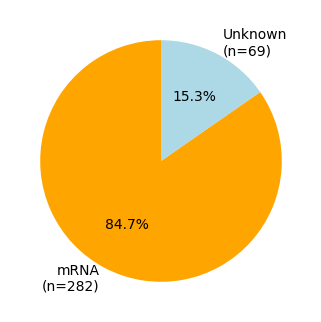

In [3]:
colours = { 
            "mRNA\n(n=%s)" % Counter(tabulate)["mRNA"]: 'orange',
            "Unknown\n(n=%s)" % Counter(tabulate)["Unknown"]: 'lightblue'
          }

labels = ["mRNA\n(n=%s)" % Counter(tabulate)["mRNA"], "Unknown\n(n=%s)" % Counter(tabulate)["Unknown"]]
subcolors = {a:colours[a] for a in labels if a in colours}
explode = (0.0, 0.0)

fig, ax = plt.subplots(dpi=100)
ax.pie([232, 42], explode=explode, labels=labels, autopct="%1.1f%%", colors=[subcolors[key] for key in labels], startangle=90)

#dir_out = '/home/han/proj_het_AC/notebooks_20240220_updated/output/'
#fig.savefig(dir_out+'Fig3c_transcripts_biotypes.pdf',bbox_inches='tight')

dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure3/Data/'
plt.savefig(dir_out+'Supp_Fig8g_vitro_transcripts_types.pdf',bbox_inches='tight', dpi=300) 

In [ ]:
## 2. vitro region ------------------------------
## 2. vitro region ------------------------------

In [4]:
def get_sizes(f_sizes):
    dict_sizes = {}
    with open(f_sizes, "r") as f:
        for line in f:
            row = line.strip("\r\n").split("\t")
            chrom, size = row[0], int(row[1])
            dict_sizes[chrom] = size
    return dict_sizes


def parse_annotations(f_annotations):
    dict_annotations = {}
    with open(f_annotations, "r") as f:
        for no, line in enumerate(f):
            if no == 0:
                continue
            row = line.strip("\r\n").split("\t")
            chrom, tx_start, utr_five, utr_three, tx_end = row[0], int(row[1]), int(row[2]), int(row[3]), int(row[4])
            #if utr_five < 0:
            #    utr_five = 0
            dict_annotations[chrom] = {"tx_start": tx_start, "5utr": utr_five, "3utr": utr_three, "tx_end": tx_end}

    return dict_annotations

[ 7.77200676 80.90917052 11.31882271]


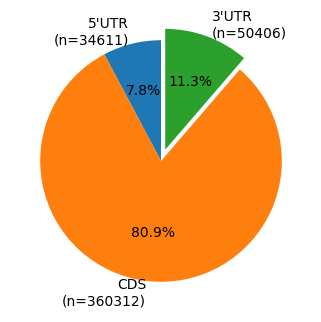

In [5]:
f_dir = "/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure3/Data/"

f_bigWigs = ["%s/modrate_30C_100mM_NAIN3.bigWig" % f_dir, 
             "%s/modrate_30Cto37C_100mM_NAIN3.bigWig" % f_dir,
             "%s/modrate_30C-IVT_100mM_NAIN3.bigWig" % f_dir, 
             "%s/modrate_37C-IVT_100mM_NAIN3.bigWig" % f_dir]

f_annotations = "/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure3/Data/bruno_et_al_2010_tx_loci.annotation"
f_sizes = "/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Figure3/Data/bruno_et_al_2010_tx_loci.sizes" 

dict_sizes = get_sizes(f_sizes)
dict_annotations = parse_annotations(f_annotations)

total_region_of_selected_chroms = np.array([0, 0, 0])
for p_chrom in p_new_chroms:

    try:
        utr_five_pos = dict_annotations[p_chrom]["5utr"]
        utr_three_pos = dict_annotations[p_chrom]["3utr"]
    except KeyError:
        continue

    total_region_of_selected_chroms[0] += utr_five_pos
    total_region_of_selected_chroms[1] += (utr_three_pos - utr_five_pos + 1)
    total_region_of_selected_chroms[2] += (dict_sizes[p_chrom] - utr_three_pos + 1)

print((total_region_of_selected_chroms/total_region_of_selected_chroms.sum())*100)


labels = ["5'UTR\n(n=%s)" % (total_region_of_selected_chroms[0]), "CDS\n(n=%s)" % (total_region_of_selected_chroms[1]), "3'UTR\n(n=%s)" % (total_region_of_selected_chroms[2])]
explode = (0.0, 0.0, 0.1)

fig, ax = plt.subplots(dpi=100)
ax.pie(total_region_of_selected_chroms, explode=explode, labels=labels, autopct="%1.1f%%", startangle=90)

dir_out = '/home/han/proj_het_AC/rerun_analysis/0_revision_v1_20250220/2_Fig5_candida_issues/Manuscript_Fig5_sFig7/Figures_PDF/'
plt.savefig(dir_out+'Supp_Fig8g_vitro_transcripts_regions.pdf',bbox_inches='tight', dpi=300) 
